In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


Part2: bigger dataset pretrain

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import re, json
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize
import unicodedata
import random
class NLIProcessor:

    def __init__(self, embed_dim=300, min_count=2, max_len=32, seed=42):
        self.embed_dim = embed_dim
        self.min_count = min_count
        self.max_len = max_len
        self.word_index = {"<pad>": 0, "<unk>": 1}
        self.embeddings = None
        random.seed(seed)
        np.random.seed(seed)


    def clean_text(self, text):
        """统一 Unicode、去除多余空白"""
        if not isinstance(text, str):
            return ""
        text = unicodedata.normalize("NFKC", text)
        text = re.sub(r"[\t\n\r]+", " ", text)
        text = re.sub(r"\s+", " ", text)
        return text.strip()


    def tokenize(self, text):

        text = self.clean_text(text)
        if re.search(r"[\u4e00-\u9fff]", text):  # 中文
            tokens = list(text)  # character-level tokenization
        else:
            tokens = wordpunct_tokenize(text)  
        return [t.lower() for t in tokens if t.strip() != ""]


    def build_vocab(self, texts):

        tokenized = [self.tokenize(t) for t in tqdm(texts, desc="Tokenizing texts")]

        print("Training Word2Vec model on multilingual corpus ...")
        self.word2vec = Word2Vec(
            tokenized,
            vector_size=self.embed_dim,
            window=5,
            min_count=self.min_count,
            workers=4,
            sg=1  # skip-gram 
        )

        # vocab
        for word in self.word2vec.wv.index_to_key:
            if word not in self.word_index:
                self.word_index[word] = len(self.word_index)

        # embedding matrix
        vocab_size = len(self.word_index)
        self.embeddings = np.zeros((vocab_size, self.embed_dim))
        for word, idx in self.word_index.items():
            if word in self.word2vec.wv:
                self.embeddings[idx] = self.word2vec.wv[word]
            else:
                self.embeddings[idx] = np.random.normal(scale=0.6, size=(self.embed_dim,))

        print(f"Vocab size: {vocab_size}")
        print(f"Embedding matrix shape: {self.embeddings.shape}")


    def encode(self, text):

        tokens = self.tokenize(text)
        ids = [self.word_index.get(tok, 1) for tok in tokens]  # 1 = <unk>

        # padding / truncation
        if len(ids) < self.max_len:
            ids += [0] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

class NLIDataset(Dataset):
    def __init__(self, df, processor):
        self.premises = df["premise"].tolist()
        self.hypotheses = df["hypothesis"].tolist()
        self.labels = df["label"].tolist()
        self.processor = processor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        p = self.processor.encode(self.premises[idx])
        h = self.processor.encode(self.hypotheses[idx])
        y = self.labels[idx]
        return torch.tensor(p), torch.tensor(h), torch.tensor(y)

df = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")  # Kaggle 数据集
df["label"] = df["label"].astype(int)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

processor = NLIProcessor(embed_dim=100)
processor.build_vocab(train_df["premise"].tolist() + train_df["hypothesis"].tolist())

train_dataset = NLIDataset(train_df, processor)
val_dataset = NLIDataset(val_df, processor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    train_acc_list, val_acc_list = [], []
    for epoch in range(1, epochs + 1):
        model.train()
        total, correct = 0, 0
        for a, b, y in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            a, b, y = a.to(device), b.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(a, b)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        # 验证
        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for a, b, y in val_loader:
                a, b, y = a.to(device), b.to(device), y.to(device)
                out = model(a, b)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return train_acc_list, val_acc_list

def plot(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Tokenizing texts: 100%|██████████| 19392/19392 [00:00<00:00, 46247.42it/s]


Training Word2Vec model on multilingual corpus ...
Vocab size: 21956
Embedding matrix shape: (21956, 100)


In [ ]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd

target_langs = ["ar", "bg", "zh", "de", "el", "en", "es", "fr",
                "hi", "ru", "sw", "th", "tr", "ur", "vi"]

samples_per_lang = 10000
dataset_name = "MoritzLaurer/multilingual-NLI-26lang-2mil7"

print("Loading dataset metadata / available splits ...")
ds_dict = load_dataset(dataset_name)
available_splits = list(ds_dict.keys())
print(f"Found {len(available_splits)} splits. Example splits: {available_splits[:12]}")

lang_to_splits = {}
for lang in target_langs:
    pref = f"{lang}_"
    matches = [s for s in available_splits if s.startswith(pref)]
    if lang in available_splits:
        matches.append(lang)
    lang_to_splits[lang] = matches
    print(f"{lang}: {len(matches)} splits")

all_lang_frames = []
for lang in tqdm(target_langs, desc="Languages"):
    splits = lang_to_splits.get(lang, [])
    if not splits:
        print(f"Warning: no splits found for language {lang}, skipping.")
        continue

    lang_datasets = []
    for s in splits:
        ds_split = ds_dict[s]
        lang_datasets.append(ds_split)

    if len(lang_datasets) == 1:
        lang_ds = lang_datasets[0]
    else:
        lang_ds = concatenate_datasets(lang_datasets)

    lang_ds_shuffled = lang_ds.shuffle(seed=42)
    take_n = min(samples_per_lang, len(lang_ds_shuffled))
    if take_n == 0:
        print(f"Warning: {lang} has 0 examples after merging splits.")
        continue
    lang_sampled = lang_ds_shuffled.select(range(take_n))

    df_lang = pd.DataFrame(lang_sampled)
    # must contain:（premise, hypothesis, label, language）
    expected_cols = ["premise", "hypothesis", "label", "language"]
    have_cols = [c for c in expected_cols if c in df_lang.columns]
    df_lang = df_lang[have_cols]
    df_lang["source_lang"] = lang  
    all_lang_frames.append(df_lang)

    print(f"Sampled {len(df_lang)} examples for language {lang}")

if all_lang_frames:
    df_all = pd.concat(all_lang_frames, ignore_index=True)
    df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"\nTotal combined samples: {len(df_all)}")
else:
    df_all = pd.DataFrame()
    print("No samples collected.")

df_x = df_all

df_x["label"] = df_x["label"].astype(int)
train_df_x = df_x.sample(frac=0.8, random_state=42)
val_df_x = df_x.drop(train_df_x.index)

processor_x = NLIProcessor(embed_dim=100)
# !!!!!!!!!!!
processor_x.build_vocab(train_df_x["premise"].tolist() + train_df_x["hypothesis"].tolist())

train_dataset_x = NLIDataset(train_df_x, processor_x)
val_dataset_x = NLIDataset(val_df_x, processor_x)

train_loader_x = DataLoader(train_dataset_x, batch_size=256, shuffle=True)
val_loader_x = DataLoader(val_dataset_x, batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading dataset metadata / available splits ...


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/ar_anli-00000-of-00001-d5ddcd7a9618(…):   0%|          | 0.00/13.2M [00:00<?, ?B/s]

data/ar_fever-00000-of-00001-75e864b8c1c(…):   0%|          | 0.00/11.9M [00:00<?, ?B/s]

data/ar_ling-00000-of-00001-f4e042f46b09(…):   0%|          | 0.00/1.13M [00:00<?, ?B/s]

data/ar_mnli-00000-of-00001-13deaea90655(…):   0%|          | 0.00/6.84M [00:00<?, ?B/s]

data/ar_wanli-00000-of-00001-7f580e9d2ef(…):   0%|          | 0.00/5.44M [00:00<?, ?B/s]

data/bn_anli-00000-of-00001-e8dbc6fc5642(…):   0%|          | 0.00/13.9M [00:00<?, ?B/s]

data/bn_fever-00000-of-00001-251d867cea0(…):   0%|          | 0.00/13.3M [00:00<?, ?B/s]

data/bn_ling-00000-of-00001-53669cb21fe1(…):   0%|          | 0.00/1.27M [00:00<?, ?B/s]

data/bn_mnli-00000-of-00001-98ed26f43373(…):   0%|          | 0.00/7.65M [00:00<?, ?B/s]

data/bn_wanli-00000-of-00001-54ba7e58f30(…):   0%|          | 0.00/6.09M [00:00<?, ?B/s]

data/de_anli-00000-of-00001-3aafac6464dd(…):   0%|          | 0.00/12.1M [00:00<?, ?B/s]

data/de_fever-00000-of-00001-e6728d1eaeb(…):   0%|          | 0.00/11.7M [00:00<?, ?B/s]

data/de_ling-00000-of-00001-0eb80cb58d7b(…):   0%|          | 0.00/1.08M [00:00<?, ?B/s]

data/de_mnli-00000-of-00001-4426e1a3eb89(…):   0%|          | 0.00/6.57M [00:00<?, ?B/s]

data/de_wanli-00000-of-00001-84103d1bded(…):   0%|          | 0.00/5.27M [00:00<?, ?B/s]

data/es_anli-00000-of-00001-3e4d4c306dfa(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

data/es_fever-00000-of-00001-e95eea23303(…):   0%|          | 0.00/10.6M [00:00<?, ?B/s]

data/es_ling-00000-of-00001-7bd5584f1233(…):   0%|          | 0.00/1.07M [00:00<?, ?B/s]

data/es_mnli-00000-of-00001-6a706a6752e5(…):   0%|          | 0.00/6.46M [00:00<?, ?B/s]

data/es_wanli-00000-of-00001-e6490f97701(…):   0%|          | 0.00/5.15M [00:00<?, ?B/s]

data/fa_anli-00000-of-00001-08015e8ce2a4(…):   0%|          | 0.00/12.4M [00:00<?, ?B/s]

data/fa_fever-00000-of-00001-65f774f13d5(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

data/fa_ling-00000-of-00001-bf0c5d0d4e3a(…):   0%|          | 0.00/1.11M [00:00<?, ?B/s]

data/fa_mnli-00000-of-00001-d2eb82aff5e3(…):   0%|          | 0.00/6.80M [00:00<?, ?B/s]

data/fa_wanli-00000-of-00001-ed33a926824(…):   0%|          | 0.00/5.39M [00:00<?, ?B/s]

data/fr_anli-00000-of-00001-406d04a5c250(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

data/fr_fever-00000-of-00001-b7ec330d622(…):   0%|          | 0.00/10.6M [00:00<?, ?B/s]

data/fr_ling-00000-of-00001-a6ce0ad48ee9(…):   0%|          | 0.00/1.09M [00:00<?, ?B/s]

data/fr_mnli-00000-of-00001-bd34f338a1b7(…):   0%|          | 0.00/6.58M [00:00<?, ?B/s]

data/fr_wanli-00000-of-00001-80e8fb092a1(…):   0%|          | 0.00/5.25M [00:00<?, ?B/s]

data/he_anli-00000-of-00001-637d0d661350(…):   0%|          | 0.00/10.4M [00:00<?, ?B/s]

data/he_fever-00000-of-00001-2e25d41f641(…):   0%|          | 0.00/10.0M [00:00<?, ?B/s]

data/he_ling-00000-of-00001-3a28d22a7330(…):   0%|          | 0.00/1.05M [00:00<?, ?B/s]

data/he_mnli-00000-of-00001-a2f2254f9157(…):   0%|          | 0.00/6.40M [00:00<?, ?B/s]

data/he_wanli-00000-of-00001-c80fd2dfa12(…):   0%|          | 0.00/5.13M [00:00<?, ?B/s]

data/hi_anli-00000-of-00001-cfd4c9c15f49(…):   0%|          | 0.00/12.5M [00:00<?, ?B/s]

data/hi_fever-00000-of-00001-d0d5b8f7c0d(…):   0%|          | 0.00/11.0M [00:00<?, ?B/s]

data/hi_ling-00000-of-00001-1bd004f4b3b6(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

data/hi_mnli-00000-of-00001-9247d222544b(…):   0%|          | 0.00/7.21M [00:00<?, ?B/s]

data/hi_wanli-00000-of-00001-221f4f1bf88(…):   0%|          | 0.00/6.03M [00:00<?, ?B/s]

data/id_anli-00000-of-00001-a5d3075569ab(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

data/id_fever-00000-of-00001-f6433fcb87c(…):   0%|          | 0.00/10.5M [00:00<?, ?B/s]

data/id_ling-00000-of-00001-bfdecaeace77(…):   0%|          | 0.00/1.01M [00:00<?, ?B/s]

data/id_mnli-00000-of-00001-048eec623b4c(…):   0%|          | 0.00/6.17M [00:00<?, ?B/s]

data/id_wanli-00000-of-00001-3331e73f169(…):   0%|          | 0.00/4.86M [00:00<?, ?B/s]

data/it_anli-00000-of-00001-9c86b81e7187(…):   0%|          | 0.00/12.1M [00:00<?, ?B/s]

data/it_fever-00000-of-00001-4f77204d0dc(…):   0%|          | 0.00/10.9M [00:00<?, ?B/s]

data/it_ling-00000-of-00001-a9c80fc29e20(…):   0%|          | 0.00/1.06M [00:00<?, ?B/s]

data/it_mnli-00000-of-00001-66e118943971(…):   0%|          | 0.00/6.44M [00:00<?, ?B/s]

data/it_wanli-00000-of-00001-3d6b3728cee(…):   0%|          | 0.00/5.17M [00:00<?, ?B/s]

data/ja_anli-00000-of-00001-b49d244e36b0(…):   0%|          | 0.00/11.9M [00:00<?, ?B/s]

data/ja_fever-00000-of-00001-dee624038a8(…):   0%|          | 0.00/11.9M [00:00<?, ?B/s]

data/ja_ling-00000-of-00001-c454b28f5a77(…):   0%|          | 0.00/1.09M [00:00<?, ?B/s]

data/ja_mnli-00000-of-00001-64b72954b6a2(…):   0%|          | 0.00/6.72M [00:00<?, ?B/s]

data/ja_wanli-00000-of-00001-c9c59feb6ca(…):   0%|          | 0.00/5.17M [00:00<?, ?B/s]

data/ko_anli-00000-of-00001-949e49c56278(…):   0%|          | 0.00/11.9M [00:00<?, ?B/s]

data/ko_fever-00000-of-00001-8158f84cf52(…):   0%|          | 0.00/11.6M [00:00<?, ?B/s]

data/ko_ling-00000-of-00001-204eb9e6e3a4(…):   0%|          | 0.00/1.08M [00:00<?, ?B/s]

data/ko_mnli-00000-of-00001-2e6b31a55797(…):   0%|          | 0.00/6.56M [00:00<?, ?B/s]

data/ko_wanli-00000-of-00001-087717904ab(…):   0%|          | 0.00/5.15M [00:00<?, ?B/s]

data/mr_anli-00000-of-00001-c106df07ee44(…):   0%|          | 0.00/10.0M [00:00<?, ?B/s]

data/mr_fever-00000-of-00001-60195a03f93(…):   0%|          | 0.00/9.30M [00:00<?, ?B/s]

data/mr_ling-00000-of-00001-74caf5c2b8d2(…):   0%|          | 0.00/904k [00:00<?, ?B/s]

data/mr_mnli-00000-of-00001-b5569125278f(…):   0%|          | 0.00/5.58M [00:00<?, ?B/s]

data/mr_wanli-00000-of-00001-ef52bd7dce6(…):   0%|          | 0.00/4.42M [00:00<?, ?B/s]

data/nl_anli-00000-of-00001-3699806aec98(…):   0%|          | 0.00/11.6M [00:00<?, ?B/s]

data/nl_fever-00000-of-00001-b15c4e4c74e(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/nl_ling-00000-of-00001-9e501e778d8b(…):   0%|          | 0.00/1.04M [00:00<?, ?B/s]

data/nl_mnli-00000-of-00001-bec288bb8bb8(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

data/nl_wanli-00000-of-00001-113a93399bb(…):   0%|          | 0.00/5.10M [00:00<?, ?B/s]

data/pl_anli-00000-of-00001-173177842815(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/pl_fever-00000-of-00001-8bf8570570c(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/pl_ling-00000-of-00001-c2820cd0fa0a(…):   0%|          | 0.00/1.08M [00:00<?, ?B/s]

data/pl_mnli-00000-of-00001-e216c3ea2964(…):   0%|          | 0.00/6.53M [00:00<?, ?B/s]

data/pl_wanli-00000-of-00001-6ebacc18bc7(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

data/ps_anli-00000-of-00001-8df86db03379(…):   0%|          | 0.00/12.7M [00:00<?, ?B/s]

data/ps_fever-00000-of-00001-4ab8979e377(…):   0%|          | 0.00/12.2M [00:00<?, ?B/s]

data/ps_ling-00000-of-00001-c0d22535b7ed(…):   0%|          | 0.00/1.09M [00:00<?, ?B/s]

data/ps_mnli-00000-of-00001-8428c7dac48e(…):   0%|          | 0.00/6.65M [00:00<?, ?B/s]

data/ps_wanli-00000-of-00001-73d8db73e62(…):   0%|          | 0.00/5.30M [00:00<?, ?B/s]

data/pt_anli-00000-of-00001-21ca95ba4e8f(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

data/pt_fever-00000-of-00001-18425098add(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

data/pt_ling-00000-of-00001-a83548f81f2e(…):   0%|          | 0.00/1.06M [00:00<?, ?B/s]

data/pt_mnli-00000-of-00001-26d159c0e009(…):   0%|          | 0.00/6.40M [00:00<?, ?B/s]

data/pt_wanli-00000-of-00001-4fb59a850c0(…):   0%|          | 0.00/5.09M [00:00<?, ?B/s]

data/ru_anli-00000-of-00001-f2258d5b2015(…):   0%|          | 0.00/13.4M [00:00<?, ?B/s]

data/ru_fever-00000-of-00001-5b067e11d27(…):   0%|          | 0.00/12.8M [00:00<?, ?B/s]

data/ru_ling-00000-of-00001-2241982f6604(…):   0%|          | 0.00/1.24M [00:00<?, ?B/s]

data/ru_mnli-00000-of-00001-fcb02986b138(…):   0%|          | 0.00/7.55M [00:00<?, ?B/s]

data/ru_wanli-00000-of-00001-83c90cadb4c(…):   0%|          | 0.00/6.10M [00:00<?, ?B/s]

data/sv_anli-00000-of-00001-1f6b78374d02(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

data/sv_fever-00000-of-00001-135e884c9bd(…):   0%|          | 0.00/11.4M [00:00<?, ?B/s]

data/sv_ling-00000-of-00001-5e4fe5be8ca7(…):   0%|          | 0.00/1.04M [00:00<?, ?B/s]

data/sv_mnli-00000-of-00001-82f86483a7e8(…):   0%|          | 0.00/6.27M [00:00<?, ?B/s]

data/sv_wanli-00000-of-00001-4b2993805c9(…):   0%|          | 0.00/5.00M [00:00<?, ?B/s]

data/sw_anli-00000-of-00001-55facff0acfa(…):   0%|          | 0.00/10.8M [00:00<?, ?B/s]

data/sw_fever-00000-of-00001-cb3d8545907(…):   0%|          | 0.00/10.8M [00:00<?, ?B/s]

data/sw_ling-00000-of-00001-2dd3fd61634c(…):   0%|          | 0.00/1.02M [00:00<?, ?B/s]

data/sw_mnli-00000-of-00001-86f49c4944f6(…):   0%|          | 0.00/6.21M [00:00<?, ?B/s]

data/sw_wanli-00000-of-00001-111ce8f931c(…):   0%|          | 0.00/4.88M [00:00<?, ?B/s]

data/ta_anli-00000-of-00001-8f0328d2c112(…):   0%|          | 0.00/8.96M [00:00<?, ?B/s]

data/ta_fever-00000-of-00001-a7dd7f34109(…):   0%|          | 0.00/9.49M [00:00<?, ?B/s]

data/ta_ling-00000-of-00001-52464197987a(…):   0%|          | 0.00/1.10M [00:00<?, ?B/s]

data/ta_mnli-00000-of-00001-ea7bbba526e7(…):   0%|          | 0.00/6.55M [00:00<?, ?B/s]

data/ta_wanli-00000-of-00001-ad02947605a(…):   0%|          | 0.00/5.62M [00:00<?, ?B/s]

data/tr_anli-00000-of-00001-83c0236e742f(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

data/tr_fever-00000-of-00001-e53fdd42a04(…):   0%|          | 0.00/10.9M [00:00<?, ?B/s]

data/tr_ling-00000-of-00001-5f0f940d2e3d(…):   0%|          | 0.00/1.05M [00:00<?, ?B/s]

data/tr_mnli-00000-of-00001-56efd5b9813a(…):   0%|          | 0.00/6.32M [00:00<?, ?B/s]

data/tr_wanli-00000-of-00001-3b662118962(…):   0%|          | 0.00/5.00M [00:00<?, ?B/s]

data/uk_anli-00000-of-00001-928fbbaf7891(…):   0%|          | 0.00/13.4M [00:00<?, ?B/s]

data/uk_fever-00000-of-00001-0a129b539cb(…):   0%|          | 0.00/12.8M [00:00<?, ?B/s]

data/uk_ling-00000-of-00001-1a9c41899cd1(…):   0%|          | 0.00/1.22M [00:00<?, ?B/s]

data/uk_mnli-00000-of-00001-157bffbd0451(…):   0%|          | 0.00/7.36M [00:00<?, ?B/s]

data/uk_wanli-00000-of-00001-03453a81308(…):   0%|          | 0.00/5.89M [00:00<?, ?B/s]

data/ur_anli-00000-of-00001-9706a835abd6(…):   0%|          | 0.00/10.1M [00:00<?, ?B/s]

data/ur_fever-00000-of-00001-cde700c612e(…):   0%|          | 0.00/9.36M [00:00<?, ?B/s]

data/ur_ling-00000-of-00001-2a487cc4b4eb(…):   0%|          | 0.00/1.06M [00:00<?, ?B/s]

data/ur_mnli-00000-of-00001-ac072d7484e3(…):   0%|          | 0.00/6.41M [00:00<?, ?B/s]

data/ur_wanli-00000-of-00001-a5ab0b9a749(…):   0%|          | 0.00/5.40M [00:00<?, ?B/s]

data/vi_anli-00000-of-00001-7e787be6ac1f(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/vi_fever-00000-of-00001-f716544ff72(…):   0%|          | 0.00/10.8M [00:00<?, ?B/s]

data/vi_ling-00000-of-00001-9fffc9d6c215(…):   0%|          | 0.00/1.05M [00:00<?, ?B/s]

data/vi_mnli-00000-of-00001-7932e0643171(…):   0%|          | 0.00/6.50M [00:00<?, ?B/s]

data/vi_wanli-00000-of-00001-6bcb1563253(…):   0%|          | 0.00/5.20M [00:00<?, ?B/s]

data/zh_anli-00000-of-00001-badbb4c3fd4e(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/zh_fever-00000-of-00001-b6bb1bca5e3(…):   0%|          | 0.00/10.9M [00:00<?, ?B/s]

data/zh_ling-00000-of-00001-fa88ac91eac1(…):   0%|          | 0.00/978k [00:00<?, ?B/s]

data/zh_mnli-00000-of-00001-7cdc260bd1a5(…):   0%|          | 0.00/5.94M [00:00<?, ?B/s]

data/zh_wanli-00000-of-00001-9449492634a(…):   0%|          | 0.00/4.75M [00:00<?, ?B/s]

Generating ar_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ar_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ar_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ar_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ar_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating bn_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating bn_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating bn_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating bn_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating bn_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating de_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating de_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating de_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating de_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating de_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating es_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating es_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating es_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating es_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating es_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fa_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fa_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fa_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating fa_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fa_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fr_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fr_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fr_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating fr_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating fr_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating he_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating he_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating he_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating he_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating he_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating hi_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating hi_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating hi_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating hi_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating hi_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating id_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating id_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating id_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating id_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating id_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating it_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating it_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating it_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating it_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating it_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ja_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ja_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ja_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ja_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ja_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ko_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ko_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ko_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ko_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ko_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating mr_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating mr_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating mr_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating mr_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating mr_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating nl_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating nl_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating nl_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating nl_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating nl_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pl_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pl_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pl_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating pl_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pl_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ps_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ps_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ps_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ps_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ps_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pt_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pt_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pt_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating pt_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating pt_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ru_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ru_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ru_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ru_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ru_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sv_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sv_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sv_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating sv_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sv_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sw_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sw_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sw_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating sw_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating sw_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ta_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ta_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ta_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ta_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ta_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating tr_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating tr_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating tr_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating tr_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating tr_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating uk_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating uk_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating uk_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating uk_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating uk_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ur_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ur_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ur_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating ur_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating ur_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating vi_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating vi_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating vi_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating vi_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating vi_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating zh_anli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating zh_fever split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating zh_ling split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating zh_mnli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating zh_wanli split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Found 130 splits. Example splits: ['ar_anli', 'ar_fever', 'ar_ling', 'ar_mnli', 'ar_wanli', 'bn_anli', 'bn_fever', 'bn_ling', 'bn_mnli', 'bn_wanli', 'de_anli', 'de_fever']
ar: 5 splits
bg: 0 splits
zh: 5 splits
de: 5 splits
el: 0 splits
en: 0 splits
es: 5 splits
fr: 5 splits
hi: 5 splits
ru: 5 splits
sw: 5 splits
th: 0 splits
tr: 5 splits
ur: 5 splits
vi: 5 splits


Languages:   7%|▋         | 1/15 [00:01<00:14,  1.02s/it]

Sampled 10000 examples for language ar


Languages:  20%|██        | 3/15 [00:02<00:07,  1.58it/s]

Sampled 10000 examples for language zh


Languages:  27%|██▋       | 4/15 [00:03<00:08,  1.32it/s]

Sampled 10000 examples for language de


Languages:  47%|████▋     | 7/15 [00:04<00:04,  1.99it/s]

Sampled 10000 examples for language es


Languages:  53%|█████▎    | 8/15 [00:05<00:04,  1.52it/s]

Sampled 10000 examples for language fr


Languages:  60%|██████    | 9/15 [00:06<00:05,  1.16it/s]

Sampled 10000 examples for language hi


Languages:  67%|██████▋   | 10/15 [00:07<00:04,  1.11it/s]

Sampled 10000 examples for language ru


Languages:  73%|███████▎  | 11/15 [00:08<00:03,  1.09it/s]

Sampled 10000 examples for language sw


Languages:  87%|████████▋ | 13/15 [00:09<00:01,  1.33it/s]

Sampled 10000 examples for language tr


Languages:  93%|█████████▎| 14/15 [00:10<00:00,  1.20it/s]

Sampled 10000 examples for language ur


Languages: 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Sampled 10000 examples for language vi

Total combined samples: 110000


Tokenizing texts: 100%|██████████| 176000/176000 [00:06<00:00, 28778.35it/s]


Training Word2Vec model on multilingual corpus ...
Vocab size: 129502
Embedding matrix shape: (129502, 100)


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, embed_matrix, hidden=128, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden * 8, num_classes)

    def encode(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return torch.cat((h[0], h[1]), dim=1)

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

In [5]:
print(f"\n=== pre-Training LSTM ===")
model = LSTMModel(processor_x.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader_x, val_loader_x, criterion, optimizer, device, epochs=10)
print(train_acc)
print(val_acc)


=== pre-Training LSTM ===


Train Epoch 1: 100%|██████████| 344/344 [00:16<00:00, 20.45it/s]


Epoch 1: Train Acc=0.4327, Val Acc=0.4469


Train Epoch 2: 100%|██████████| 344/344 [00:15<00:00, 22.29it/s]


Epoch 2: Train Acc=0.5234, Val Acc=0.4834


Train Epoch 3: 100%|██████████| 344/344 [00:15<00:00, 22.34it/s]


Epoch 3: Train Acc=0.6797, Val Acc=0.4695


Train Epoch 4: 100%|██████████| 344/344 [00:15<00:00, 22.03it/s]


Epoch 4: Train Acc=0.8153, Val Acc=0.4572


Train Epoch 5: 100%|██████████| 344/344 [00:15<00:00, 22.00it/s]


Epoch 5: Train Acc=0.8834, Val Acc=0.4466


Train Epoch 6: 100%|██████████| 344/344 [00:15<00:00, 22.12it/s]


Epoch 6: Train Acc=0.9185, Val Acc=0.4480


Train Epoch 7: 100%|██████████| 344/344 [00:15<00:00, 21.90it/s]


Epoch 7: Train Acc=0.9391, Val Acc=0.4434


Train Epoch 8: 100%|██████████| 344/344 [00:16<00:00, 21.32it/s]


Epoch 8: Train Acc=0.9534, Val Acc=0.4446


Train Epoch 9: 100%|██████████| 344/344 [00:15<00:00, 21.73it/s]


Epoch 9: Train Acc=0.9639, Val Acc=0.4386


Train Epoch 10: 100%|██████████| 344/344 [00:15<00:00, 21.78it/s]


Epoch 10: Train Acc=0.9709, Val Acc=0.4397
[0.43273863636363635, 0.5233522727272727, 0.67975, 0.8152727272727273, 0.8833863636363637, 0.9184772727272728, 0.939125, 0.9533636363636364, 0.9638863636363636, 0.9709090909090909]
[0.44686363636363635, 0.4833636363636364, 0.4695, 0.4572272727272727, 0.4465909090909091, 0.44795454545454544, 0.4434090909090909, 0.4445909090909091, 0.4385909090909091, 0.4396818181818182]



=== fine-tuning LSTM ===


Train Epoch 1: 100%|██████████| 152/152 [00:02<00:00, 64.52it/s]


Epoch 1: Train Acc=0.4479, Val Acc=0.3866


Train Epoch 2: 100%|██████████| 152/152 [00:02<00:00, 67.39it/s]


Epoch 2: Train Acc=0.5814, Val Acc=0.3647


Train Epoch 3: 100%|██████████| 152/152 [00:02<00:00, 67.50it/s]


Epoch 3: Train Acc=0.7282, Val Acc=0.3568


Train Epoch 4: 100%|██████████| 152/152 [00:02<00:00, 68.08it/s]


Epoch 4: Train Acc=0.8514, Val Acc=0.3432


Train Epoch 5: 100%|██████████| 152/152 [00:02<00:00, 65.85it/s]


Epoch 5: Train Acc=0.9186, Val Acc=0.3321


Train Epoch 6: 100%|██████████| 152/152 [00:02<00:00, 66.64it/s]


Epoch 6: Train Acc=0.9533, Val Acc=0.3474


Train Epoch 7: 100%|██████████| 152/152 [00:02<00:00, 67.39it/s]


Epoch 7: Train Acc=0.9749, Val Acc=0.3428


Train Epoch 8: 100%|██████████| 152/152 [00:02<00:00, 67.44it/s]


Epoch 8: Train Acc=0.9850, Val Acc=0.3568


Train Epoch 9: 100%|██████████| 152/152 [00:02<00:00, 67.43it/s]


Epoch 9: Train Acc=0.9916, Val Acc=0.3585


Train Epoch 10: 100%|██████████| 152/152 [00:02<00:00, 67.09it/s]


Epoch 10: Train Acc=0.9947, Val Acc=0.3412
[0.4479166666666667, 0.5813737623762376, 0.7282384488448845, 0.8513820132013201, 0.9186262376237624, 0.9532797029702971, 0.9749381188118812, 0.9850453795379538, 0.9916460396039604, 0.994740099009901]
[0.3865511551155115, 0.36468646864686466, 0.35684818481848185, 0.3432343234323432, 0.3320957095709571, 0.34735973597359737, 0.34282178217821785, 0.35684818481848185, 0.3584983498349835, 0.3411716171617162]


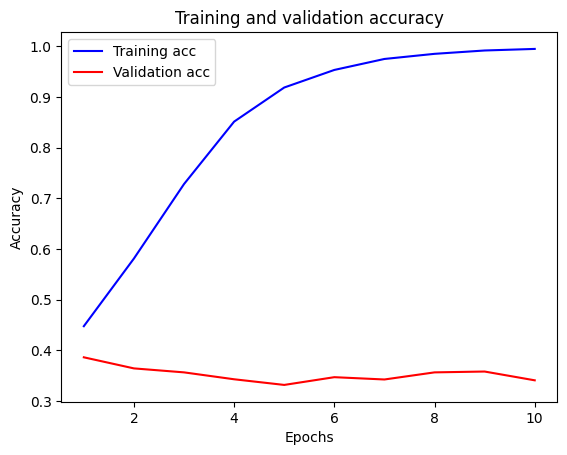

In [7]:
print(f"\n=== fine-tuning LSTM ===")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
print(train_acc)
print(val_acc)
plot(train_acc, val_acc)

In [9]:
class CNNModel(nn.Module):
    def __init__(self, embed_matrix, num_classes=3):
        super().__init__()
        vocab_size, embed_dim = embed_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embed_matrix, dtype=torch.float32), freeze=False)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128 * 4, num_classes)

    def encode(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        return x

    def forward(self, a, b):
        va, vb = self.encode(a), self.encode(b)
        v = torch.cat([va, vb, torch.abs(va - vb), va * vb], dim=1)
        return self.fc(v)

In [10]:
print(f"\n=== pre-Training cnn ===")
model = CNNModel(processor_x.embeddings).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc, val_acc = train_model(model, train_loader_x, val_loader_x, criterion, optimizer, device, epochs=10)
print(train_acc)
print(val_acc)


=== pre-Training cnn ===


Train Epoch 1: 100%|██████████| 344/344 [00:13<00:00, 26.22it/s]


Epoch 1: Train Acc=0.4347, Val Acc=0.4577


Train Epoch 2: 100%|██████████| 344/344 [00:13<00:00, 25.40it/s]


Epoch 2: Train Acc=0.5126, Val Acc=0.4836


Train Epoch 3: 100%|██████████| 344/344 [00:13<00:00, 25.52it/s]


Epoch 3: Train Acc=0.6464, Val Acc=0.4805


Train Epoch 4: 100%|██████████| 344/344 [00:13<00:00, 25.18it/s]


Epoch 4: Train Acc=0.8112, Val Acc=0.4665


Train Epoch 5: 100%|██████████| 344/344 [00:13<00:00, 25.57it/s]


Epoch 5: Train Acc=0.9114, Val Acc=0.4563


Train Epoch 6: 100%|██████████| 344/344 [00:13<00:00, 25.68it/s]


Epoch 6: Train Acc=0.9562, Val Acc=0.4568


Train Epoch 7: 100%|██████████| 344/344 [00:13<00:00, 25.91it/s]


Epoch 7: Train Acc=0.9752, Val Acc=0.4501


Train Epoch 8: 100%|██████████| 344/344 [00:13<00:00, 25.82it/s]


Epoch 8: Train Acc=0.9848, Val Acc=0.4564


Train Epoch 9: 100%|██████████| 344/344 [00:13<00:00, 25.65it/s]


Epoch 9: Train Acc=0.9902, Val Acc=0.4607


Train Epoch 10: 100%|██████████| 344/344 [00:13<00:00, 25.57it/s]


Epoch 10: Train Acc=0.9936, Val Acc=0.4580
[0.43471590909090907, 0.5125681818181819, 0.6464090909090909, 0.8112386363636364, 0.9113863636363636, 0.9561931818181818, 0.9751931818181818, 0.9848181818181818, 0.9901931818181818, 0.9936477272727273]
[0.4577272727272727, 0.48359090909090907, 0.48054545454545455, 0.46645454545454546, 0.4562727272727273, 0.4567727272727273, 0.4500909090909091, 0.45640909090909093, 0.4606818181818182, 0.458]



=== fine-tuning CNN ===


Train Epoch 1: 100%|██████████| 152/152 [00:01<00:00, 76.50it/s]


Epoch 1: Train Acc=0.3552, Val Acc=0.3540


Train Epoch 2: 100%|██████████| 152/152 [00:01<00:00, 77.87it/s]


Epoch 2: Train Acc=0.5950, Val Acc=0.3585


Train Epoch 3: 100%|██████████| 152/152 [00:01<00:00, 77.52it/s]


Epoch 3: Train Acc=0.8034, Val Acc=0.3523


Train Epoch 4: 100%|██████████| 152/152 [00:01<00:00, 79.45it/s]


Epoch 4: Train Acc=0.9240, Val Acc=0.3498


Train Epoch 5: 100%|██████████| 152/152 [00:01<00:00, 79.98it/s]


Epoch 5: Train Acc=0.9704, Val Acc=0.3453


Train Epoch 6: 100%|██████████| 152/152 [00:01<00:00, 80.00it/s]


Epoch 6: Train Acc=0.9882, Val Acc=0.3507


Train Epoch 7: 100%|██████████| 152/152 [00:01<00:00, 79.60it/s]


Epoch 7: Train Acc=0.9945, Val Acc=0.3465


Train Epoch 8: 100%|██████████| 152/152 [00:01<00:00, 76.59it/s]


Epoch 8: Train Acc=0.9968, Val Acc=0.3494


Train Epoch 9: 100%|██████████| 152/152 [00:01<00:00, 79.60it/s]


Epoch 9: Train Acc=0.9978, Val Acc=0.3474


Train Epoch 10: 100%|██████████| 152/152 [00:01<00:00, 79.74it/s]


Epoch 10: Train Acc=0.9981, Val Acc=0.3478
[0.3551980198019802, 0.5949876237623762, 0.803424092409241, 0.9239892739273927, 0.9704001650165016, 0.9882425742574258, 0.9945338283828383, 0.996802805280528, 0.9978341584158416, 0.9981435643564357]
[0.35396039603960394, 0.3584983498349835, 0.3523102310231023, 0.34983498349834985, 0.34529702970297027, 0.35066006600660066, 0.3465346534653465, 0.3494224422442244, 0.34735973597359737, 0.34777227722772275]


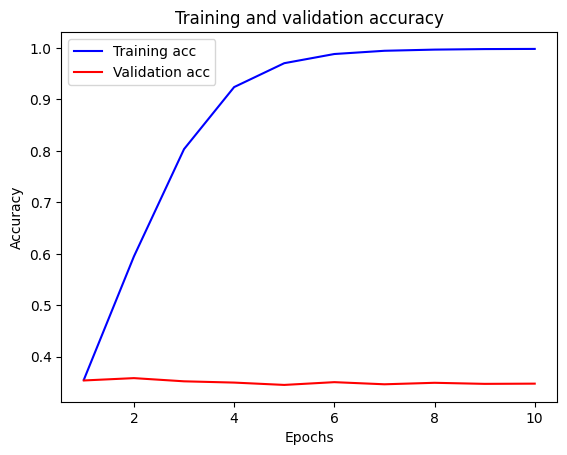

In [11]:
print(f"\n=== fine-tuning CNN ===")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
print(train_acc)
print(val_acc)
plot(train_acc, val_acc)

Part3: transfer learning

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [3]:
model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.config.hidden_dropout_prob = 0.2
model.to(torch.device(device))

2025-10-18 17:18:15.523274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760807895.540253     238 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760807895.545329     238 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [ ]:


class NLIDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoded = self.tokenizer(
            row['premise'],
            row['hypothesis'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        if 'label' in row:
            item['labels'] = torch.tensor(row['label'])
        return item



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


train_df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test_df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')

train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = NLIDataset(train_data, tokenizer)
val_dataset = NLIDataset(val_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


optimizer = AdamW(model.parameters(), lr=2e-5)

def train_one_epoch():
  
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for step, batch in enumerate(train_loader, 1):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)


        # print every 10 batches
        if step % 10 == 0 or step == len(train_loader):
            avg_loss = total_loss / step
            acc = correct / total
            print(f"Step {step}/{len(train_loader)} - Avg Loss: {avg_loss:.4f} - Acc: {acc:.4f}")

    avg_loss = total_loss / len(train_loader)
    acc = correct / total
    return avg_loss, acc

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch()
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f},Train acc= {train_acc:.4f},Val Acc={val_acc:.4f}")



Step 10/682 - Avg Loss: 1.8998 - Acc: 0.3750
Step 20/682 - Avg Loss: 1.4604 - Acc: 0.4156
Step 30/682 - Avg Loss: 1.2789 - Acc: 0.4375
Step 40/682 - Avg Loss: 1.1410 - Acc: 0.4813
Step 50/682 - Avg Loss: 1.0465 - Acc: 0.5325
Step 60/682 - Avg Loss: 1.0106 - Acc: 0.5573
Step 70/682 - Avg Loss: 0.9551 - Acc: 0.5848
Step 80/682 - Avg Loss: 0.8978 - Acc: 0.6156
Step 90/682 - Avg Loss: 0.8406 - Acc: 0.6410
Step 100/682 - Avg Loss: 0.7856 - Acc: 0.6687
Step 110/682 - Avg Loss: 0.7465 - Acc: 0.6864
Step 120/682 - Avg Loss: 0.7136 - Acc: 0.7031
Step 130/682 - Avg Loss: 0.6869 - Acc: 0.7163
Step 140/682 - Avg Loss: 0.6652 - Acc: 0.7272
Step 150/682 - Avg Loss: 0.6498 - Acc: 0.7367
Step 160/682 - Avg Loss: 0.6273 - Acc: 0.7469
Step 170/682 - Avg Loss: 0.6049 - Acc: 0.7566
Step 180/682 - Avg Loss: 0.5901 - Acc: 0.7642
Step 190/682 - Avg Loss: 0.5790 - Acc: 0.7691
Step 200/682 - Avg Loss: 0.5761 - Acc: 0.7725
Step 210/682 - Avg Loss: 0.5650 - Acc: 0.7783
Step 220/682 - Avg Loss: 0.5586 - Acc: 0.78

In [6]:
model.save_pretrained("/kaggle/working/xlmr")
tokenizer.save_pretrained("/kaggle/working/xlmr")

('/kaggle/working/xlmr/tokenizer_config.json',
 '/kaggle/working/xlmr/special_tokens_map.json',
 '/kaggle/working/xlmr/sentencepiece.bpe.model',
 '/kaggle/working/xlmr/added_tokens.json',
 '/kaggle/working/xlmr/tokenizer.json')